# *Twitter Sentiment Classification with SVM: Analyzing Public Opinion*


 Import Required Libraries

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mvy48\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mvy48\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Load the Training and Validation Data

In [118]:
train_file_path = r"C:\Users\mvy48\OneDrive\Documents\new\projects\twitter_semtiment_analysis\twitter_training.csv"
train_data = pd.read_csv(train_file_path)

val_file_path = r"C:\Users\mvy48\OneDrive\Documents\new\projects\twitter_semtiment_analysis\twitter_validation.csv"
val_data = pd.read_csv(val_file_path)

train_data.columns = ['ID', 'Topic', 'Sentiment', 'Text']
val_data.columns = ['ID', 'Topic', 'Sentiment', 'Text']

Check the Training Data

In [119]:
train_data.head()

,ID,Topic,Sentiment,Text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


Check the Validation Data

In [120]:
val_data.head()

,ID,Topic,Sentiment,Text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


Select First 10,000 Rows of Training Data and First 3,000 Rows of Validation Data
python
Copy code


In [121]:
train_data = train_data.head(10000)
val_data = val_data.head(3000)

print(f"Training data size: {train_data.shape}")
print(f"Validation data size: {val_data.shape}")


Training data size: (10000, 4)
Validation data size: (999, 4)


 Check for Missing Values

In [122]:
print(train_data['Text'].isnull().sum())
print(val_data['Text'].isnull().sum())


112
0


 Check for Missing Values and Fill Them

In [123]:

train_data['Text'].fillna("neutral", inplace=True)

val_data['Text'].fillna("neutral", inplace=True)

print(train_data['Text'].isnull().sum())
print(val_data['Text'].isnull().sum())


0
0


Visualize Sentiment Distribution

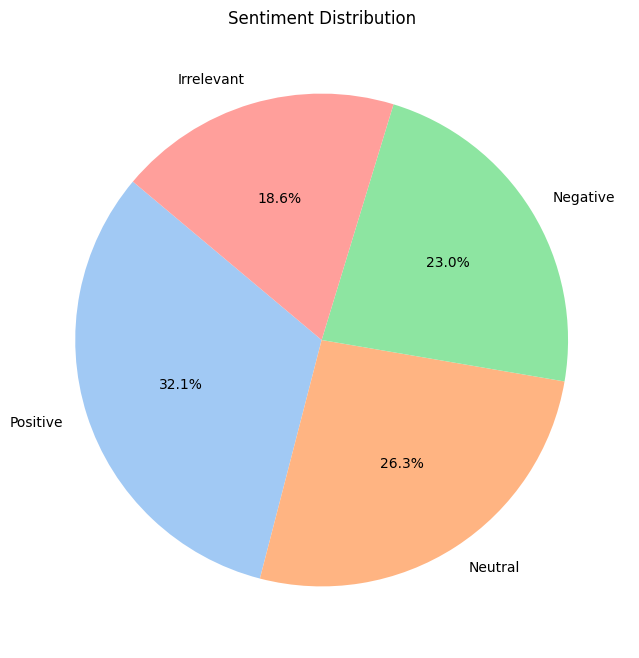

In [124]:
sentiment_counts = train_data['Sentiment'].value_counts()

plt.figure(figsize=(8, 8))
sentiment_counts.plot.pie(
    autopct='%1.1f%%',  
    startangle=140,    
    colors=sns.color_palette('pastel')  
)
plt.title('Sentiment Distribution')
plt.ylabel('')  
plt.show()


Generate Word Cloud for Each Sentiment

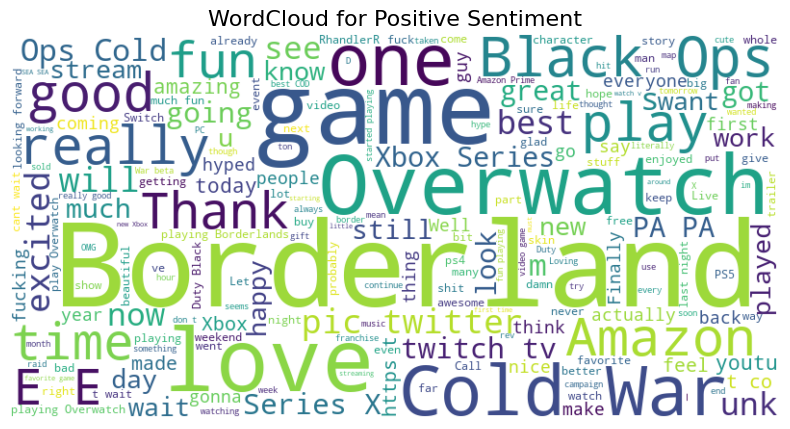

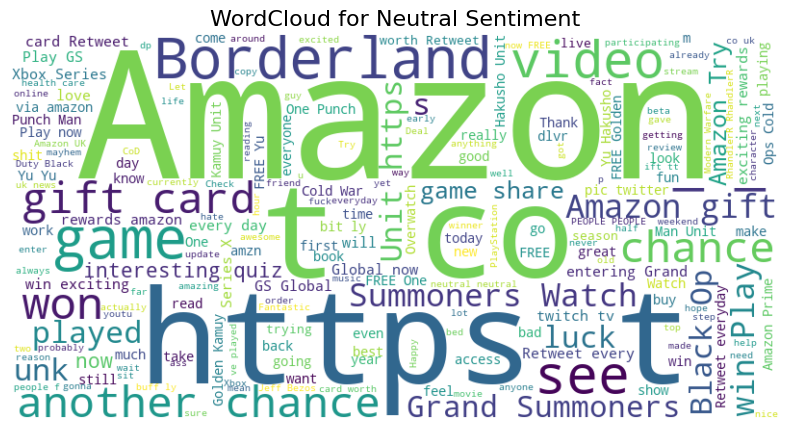

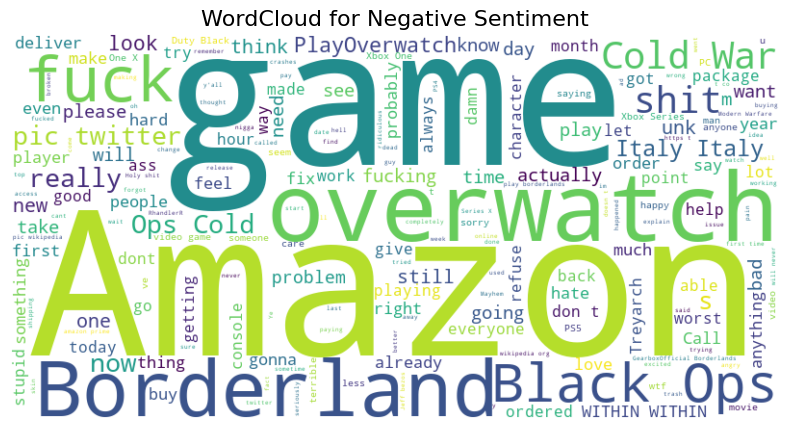

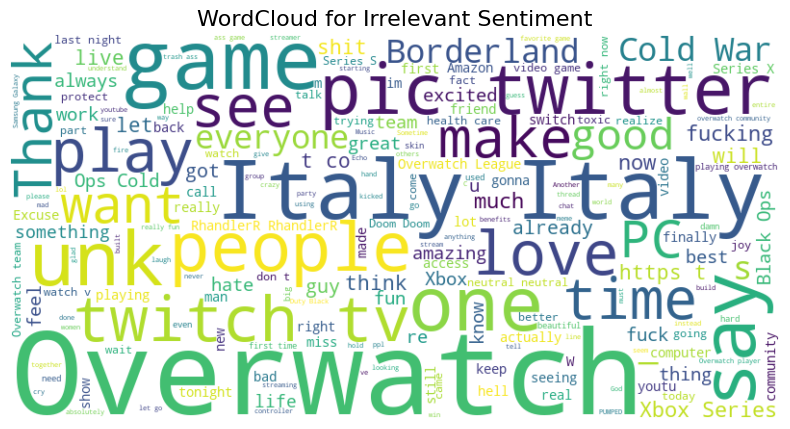

In [125]:
def generate_wordcloud(sentiment):
    sentiment_text = " ".join(train_data[train_data['Sentiment'] == sentiment]['Text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sentiment_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for {sentiment} Sentiment", fontsize=16)
    plt.show()

for sentiment in train_data['Sentiment'].unique():
    generate_wordcloud(sentiment)


Preprocess the Text Data

In [126]:
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  
    text = re.sub(r'@\w+', '', text)   
    text = re.sub(r'#', '', text)      
    text = re.sub(r'[^\w\s]', '', text) 
    text = text.lower()                 
    tokens = word_tokenize(text)        
    tokens = [word for word in tokens if word not in stopwords.words('english')] 
    return " ".join(tokens)

train_data['Cleaned_Text'] = train_data['Text'].apply(preprocess_text)
val_data['Cleaned_Text'] = val_data['Text'].apply(preprocess_text)


Encode Sentiments into Numeric Labels

In [127]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

train_data['Sentiment_Label'] = le.fit_transform(train_data['Sentiment'])
val_data['Sentiment_Label'] = le.transform(val_data['Sentiment'])

print(train_data[['Sentiment', 'Sentiment_Label']].head())
print(val_data[['Sentiment', 'Sentiment_Label']].head())


  Sentiment  Sentiment_Label
0  Positive                3
1  Positive                3
2  Positive                3
3  Positive                3
4  Positive                3
  Sentiment  Sentiment_Label
0   Neutral                2
1  Negative                1
2  Negative                1
3   Neutral                2
4  Negative                1


 Split Training Data into Train and Test (80% Train, 20% Test)

In [128]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data['Cleaned_Text'], 
    train_data['Sentiment_Label'], 
    test_size=0.2, 
    random_state=42
)
print(f"Training data size after split: {X_train.shape}")
print(f"Testing data size after split: {X_test.shape}")

Training data size after split: (8000,)
Testing data size after split: (2000,)


Vectorize the Text Data for Training, Testing, and Validation

In [129]:
vectorizer = TfidfVectorizer(max_features=5000)

X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)
X_val_vect = vectorizer.transform(val_data['Cleaned_Text'])

print(X_train_vect.shape)
print(X_test_vect.shape)
print(X_val_vect.shape)

(8000, 5000)
(2000, 5000)
(999, 5000)


Train the SVM Model

In [130]:
svm_model = SVC(kernel='linear', random_state=42)

svm_model.fit(X_train_vect, y_train)


SVC(kernel='linear', random_state=42)

Evaluate the Model on Test and Validation Data

In [131]:
y_test_pred = svm_model.predict(X_test_vect)
print("Classification Report for Test Data:")
print(classification_report(y_test, y_test_pred))

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on test data: {test_accuracy * 100:.2f}%")

y_val_pred = svm_model.predict(X_val_vect)

print("Classification Report for Validation Data:")
print(classification_report(val_data['Sentiment_Label'], y_val_pred))

val_accuracy = accuracy_score(val_data['Sentiment_Label'], y_val_pred)
print(f"Accuracy on validation data: {val_accuracy * 100:.2f}%")

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       371
           1       0.89      0.88      0.89       465
           2       0.92      0.84      0.88       521
           3       0.81      0.93      0.87       643

    accuracy                           0.87      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.88      0.87      0.87      2000

Accuracy on test data: 87.30%
Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.34      0.46      0.40       171
           1       0.58      0.50      0.54       266
           2       0.51      0.34      0.40       285
           3       0.51      0.64      0.57       277

    accuracy                           0.49       999
   macro avg       0.48      0.49      0.48       999
weighted avg       0.50      0.49      0.48       999

Accuracy on validati

Plot Confusion Matrix for Test Data

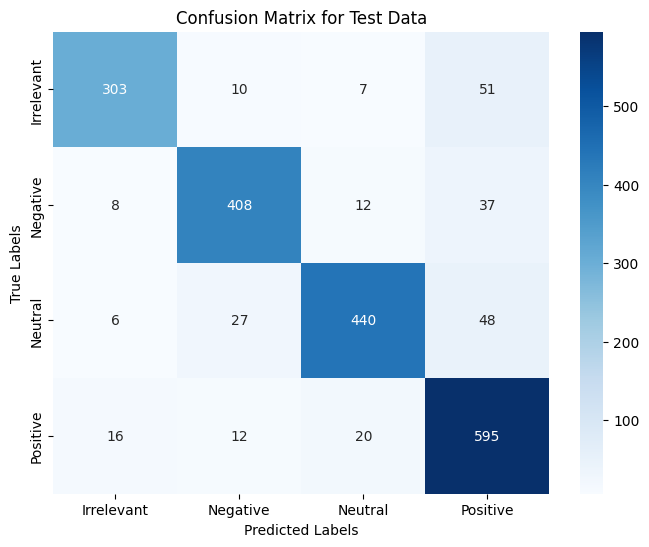

In [132]:
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
conf_matrix_val = confusion_matrix(val_data['Sentiment_Label'], y_val_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Test Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Plot Confusion Matrix for Validation Data

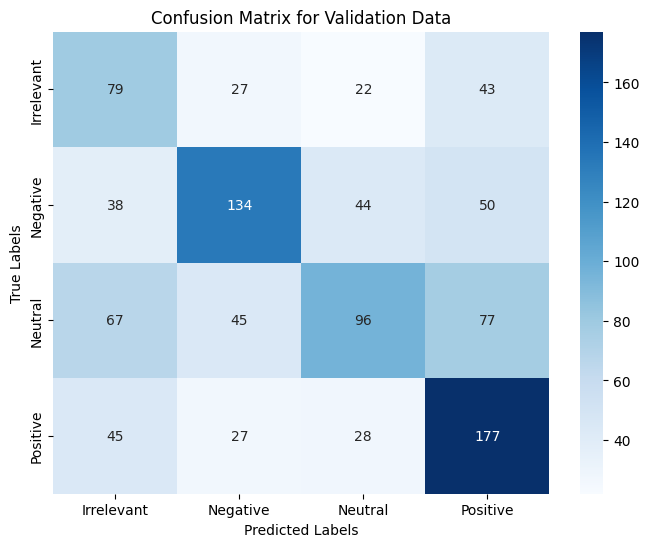

In [133]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Validation Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Classify New Input Text Using the Trained Model

In [134]:
def classify_new_text(new_text):
    cleaned_text = preprocess_text(new_text)
    
    vect_text = vectorizer.transform([cleaned_text])
    
    sentiment_pred = svm_model.predict(vect_text)
    
    sentiment_label = le.inverse_transform(sentiment_pred)
    
    return sentiment_label[0]

new_input_text = "I love playing on Twitter, it's so much fun!"
predicted_sentiment = classify_new_text(new_input_text)
print(f"The predicted sentiment for the input is: {predicted_sentiment}")


The predicted sentiment for the input is: Positive
